In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/home/ksaab/Documents/domino")
from domino.data.cxr import build_cxr_df, get_dp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from gaze_utils import plot_saccade, generate_ideal_observer
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from dtw import *
from functools import partial

from domino.data.cxr.gaze_utils import (
    apply_lf,
    diffusivity,
    make_heatmaps,
    max_visit,
    total_time,
    unique_visits,
)

211109-17:57:18,544 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.0


/home/ksaab/Documents/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Get CXR datapanel

In [3]:
df = build_cxr_df(root_dir="/media/4tb_hdd/siim")  # .out(load=True)
dp = get_dp(df)

In [4]:
dp.keys()

['image_id',
 'encoded_pixels',
 'pmx',
 'filepath',
 'chest_tube',
 'split',
 'gaze_seq',
 'gaze_max_visit',
 'gaze_unique',
 'gaze_time',
 'gaze_diffusivity',
 'expert_label',
 'padded_gaze_seq',
 'gaze_seq_len',
 'index',
 'input',
 'img',
 'segmentation',
 'segmentation_target']

In [5]:
gaze_mask = dp["gaze_seq"].data.astype(str) != "nan"
dp = dp.lz[gaze_mask]
len(dp)

951

## Plot image with segmentation mask and saccade

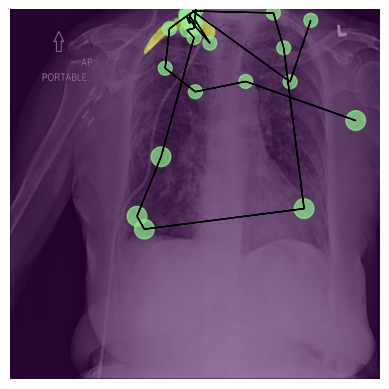

In [6]:
dp_pos = dp.lz[dp["pmx"]==1]

ndx=0

img = dp_pos[ndx]["img"]

seg_mask = dp_pos[ndx]["segmentation"]
seg_mask = Image.fromarray(np.uint8(seg_mask))

gaze_seq = dp_pos[ndx]["gaze_seq"]

plt.imshow(img, cmap="gray")
plt.imshow(seg_mask, alpha=0.5)
plot_saccade(gaze_seq)

plt.axis("OFF")
plt.show()

## Simulate ideal searcher

In [7]:
# define the hyperparameters for the detectibility map
alpha = 2 #3.28 used in rashidi et al.
beta = 5 # random guess for now
threshold = 0.99 # threshold for stopping the search

# define resolution of image
p = 15

# use same starting point as radiologist
human_seq = gaze_seq.numpy()
starting_loc = (human_seq[0][0], human_seq[0][1])


# ideal_gaze_seq = generate_ideal_observer(starting_loc, alpha, beta, dp_pos[ndx]["segmentation"], p, threshold)

# plt.imshow(img, cmap="gray")
# plt.imshow(seg_mask, alpha=0.5)
# plot_saccade(np.array(ideal_gaze_seq))

# plt.axis("OFF")
# plt.show()

### sweep over detectability params

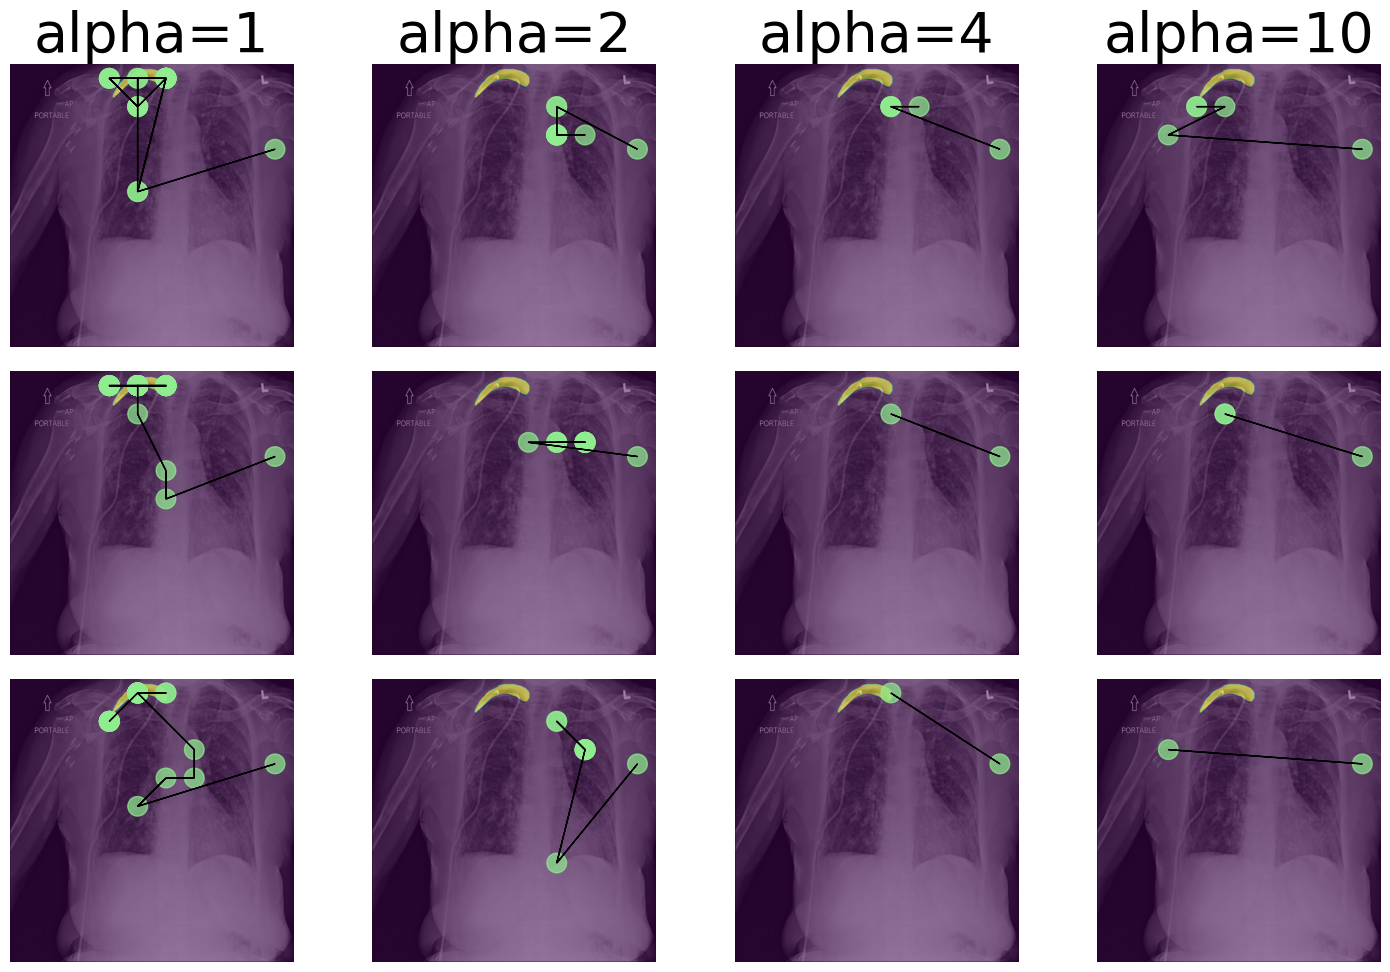

In [8]:
alpha_vals = [1,2,4,10] 
num_trials =3
p = 10
beta=3
threshold=0.99
c=0.02

fig, axs = plt.subplots(num_trials,len(alpha_vals), figsize=(15,10))
for ndx, alpha in enumerate(alpha_vals):
    for i in range(num_trials):
        ideal_gaze_seq = generate_ideal_observer(starting_loc, alpha, beta, dp_pos[ndx]["segmentation"], p, threshold, c=c)

        axs[i,ndx].imshow(img, cmap="gray")
        axs[i,ndx].imshow(seg_mask, alpha=0.5)
        plot_saccade(np.array(ideal_gaze_seq), 200, axs[i,ndx])
        axs[i,ndx].axis("off")
        if i == 0:
            axs[i,ndx].set_title(f"alpha={alpha}", fontsize=40)


plt.tight_layout()
plt.show()

## Correlations to incorrect predictions

In [9]:
incorrect_labels = np.array(dp["expert_label"] != dp["pmx"]).astype(int)
print(f"# incorrect labels: {incorrect_labels.sum()}\t avg: {incorrect_labels.mean():.3f}")
pmx_labels = dp["pmx"]

gaze_feat_names = ['gaze_max_visit','gaze_unique','gaze_time','gaze_diffusivity']
for gaze_name in gaze_feat_names:
    gaze_feats = dp[gaze_name]
    print(f"{gaze_name}: AUROC of predicting incorrect label: {roc_auc_score(incorrect_labels, gaze_feats):.3f}, for predicting pmx label: {roc_auc_score(pmx_labels, gaze_feats):.3f}")

# incorrect labels: 91	 avg: 0.096
gaze_max_visit: AUROC of predicting incorrect label: 0.751, for predicting pmx label: 0.719
gaze_unique: AUROC of predicting incorrect label: 0.685, for predicting pmx label: 0.607
gaze_time: AUROC of predicting incorrect label: 0.769, for predicting pmx label: 0.717
gaze_diffusivity: AUROC of predicting incorrect label: 0.570, for predicting pmx label: 0.638


In [15]:
# compare number of fixations from ideal observer to expert
p = 2
alpha = 5
beta=3
threshold=0.99
c=0.02

# for p in ([5]):
#     for alpha in [5]:

ideal_gaze_seqs = []
gaze_seqs = []
abs_diff = []
dtw_dist = []
for ndx in tqdm(range(len(dp))):
    gaze_seq = dp[ndx]["gaze_seq"].numpy()
    starting_loc = (gaze_seq[0][0], gaze_seq[0][1])
    ideal_gaze_seq = generate_ideal_observer(starting_loc, alpha, beta, dp[ndx]["segmentation"], p, threshold, c=c)
    
    ideal_gaze_seqs.append(ideal_gaze_seq)
    gaze_seqs.append(gaze_seq)
    abs_diff.append(np.abs(len(ideal_gaze_seq)-len(gaze_seq))/len(gaze_seq))

    gaze_seq_ = np.array([(entry[0], entry[1]) for entry in gaze_seq])
    ideal_gaze_seq_ = np.array(ideal_gaze_seq)
    dtw_dist.append(dtw(gaze_seq_, ideal_gaze_seq_, keep_internals=True).normalizedDistance)

abs_diff = np.array(abs_diff)
dtw_dist = np.array(dtw_dist)
print(f"p={p}, alpha={alpha}")
print(f"AUROC of predicting incorrect label from # fixations: {roc_auc_score(incorrect_labels, abs_diff):.3f}")
print(f"AUROC of predicting incorrect label from DTW: {roc_auc_score(incorrect_labels, dtw_dist):.3f}")

100%|██████████| 951/951 [01:03<00:00, 14.90it/s]

p=2, alpha=5
AUROC of predicting incorrect label from # fixations: 0.794
AUROC of predicting incorrect label from DTW: 0.509


AUROC of predicting incorrect label from # fixations: 0.785


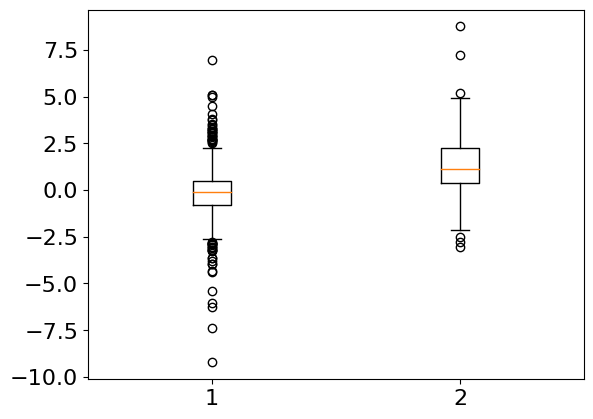

7.717867989251409e-12


In [21]:
ideal_lens = np.array([len(g) for g in ideal_gaze_seqs])
ideal_lens = ideal_lens-np.mean(ideal_lens)
ideal_lens = ideal_lens/np.std(ideal_lens)

human_lens = np.array([len(g) for g in gaze_seqs])
human_lens = human_lens-np.mean(human_lens)
human_lens = human_lens/np.std(human_lens)

preds = (human_lens-ideal_lens)
print(f"AUROC of predicting incorrect label from # fixations: {roc_auc_score(incorrect_labels, preds):.3f}")

# plt.scatter(ideal_lens, human_lens, c=incorrect_labels)
# plt.show()

mask = incorrect_labels.astype(bool)
plt.boxplot([preds[~mask], preds[mask]])
plt.show()

from scipy import stats
print(stats.ttest_ind(preds[~mask], preds[mask], equal_var=False)[1])

In [23]:
s1 = 3
s2 = 3
stride = 2
view_pct = 0.1

gaze_heatmaps = make_heatmaps(gaze_seqs)
ideal_gaze_seqs_ = [[(entry[0],entry[1],1) for entry in gaze_seq] for gaze_seq in ideal_gaze_seqs]
ideal_heatmaps = make_heatmaps(ideal_gaze_seqs_)
  
gaze_time = apply_lf(gaze_heatmaps, total_time)
gaze_max_visit = apply_lf(gaze_heatmaps, partial(max_visit, pct=view_pct))
gaze_unique = apply_lf(gaze_heatmaps, unique_visits).astype(float)
gaze_diffusivity = apply_lf(
    gaze_heatmaps, partial(diffusivity, s1=s1, s2=s2, stride=stride)
)

ideal_time = apply_lf(ideal_heatmaps, total_time)
ideal_max_visit = apply_lf(ideal_heatmaps, partial(max_visit, pct=view_pct))
ideal_unique = apply_lf(ideal_heatmaps, unique_visits).astype(float)
ideal_diffusivity = apply_lf(
    ideal_heatmaps, partial(diffusivity, s1=s1, s2=s2, stride=stride)
)

preds_all = []
for (ideal_feat, gaze_feat) in [(ideal_time,gaze_time),(ideal_max_visit,gaze_max_visit),(ideal_unique,gaze_unique)]:
    ideal_feat -= ideal_feat.mean()
    ideal_feat /= ideal_feat.std()

    gaze_feat -= gaze_feat.mean()
    gaze_feat /= gaze_feat.std()

    preds = (gaze_feat - ideal_feat)
    preds_all.append(preds)

    print(f"AUROC of predicting incorrect from gaze feature: {roc_auc_score(incorrect_labels, gaze_feat):.3f}")
    print(f"AUROC of predicting incorrect from ideal diff: {roc_auc_score(incorrect_labels, preds):.3f}\n")




1.7415928141552255e-09
AUROC of predicting incorrect from gaze feature: 0.769, p-value: None
AUROC of predicting incorrect from ideal diff: 0.781

1.482908614001404e-07
AUROC of predicting incorrect from gaze feature: 0.751, p-value: None
AUROC of predicting incorrect from ideal diff: 0.762

1.0086506754151076e-07
AUROC of predicting incorrect from gaze feature: 0.685, p-value: None
AUROC of predicting incorrect from ideal diff: 0.725

